# Building A More Complex Preprocessing Pipeline: Reddit Self-Posts Dataset

In this notebook, I will build a more complex preprocessing pipeline. Functions referred to Blueprints for Text Analytics by Albrecht et al. (2021) with several adjustments to make it more clear. For the ready-to-use functions, please refer to file **fun_nlp_spacy_text.py.** There are several steps at least until we get our prepared text:

1. Source Text (The process is called **Data Cleaning**)
    - Identify noise
    - Noise removal
    - Character normalization
    - Data masking
2. Clean Text (The process is called **Linguistic Process**)
    - Tokenization
    - POS taggin
    - Lemmatization
    - Named-entity recognition
3. Prepared Text

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3  # to save dataframe
import html
import spacy

import regex as re  # regular expression
import nltk  # library that contains stopwords, especially in english
import itertools  # to iterate items in set
import textacy.preprocessing as tprep
import fun_preprocessing_text as pp_text_1
from textacy.extract.kwic import keyword_in_context as KWIC  # to make keyword-in-context (KWIC) analysis
from wordcloud import WordCloud  # to make word clouds

from collections import Counter  # to count list contains, similar to value_counts(), but faster

In [3]:
# read the data from csv and tsv

df_posts = pd.read_csv('dataset/dataset_reddit/rspct.tsv', sep='\t')
df_subreddit = pd.read_csv('dataset/dataset_reddit/subreddit_info.csv')

display(df_posts.sample(5))
print('length of dataframe:', len(df_posts))

display(df_subreddit.sample(5))
print('length of dataframe:', len(df_subreddit))

,id,subreddit,title,selftext
95344,6gpomc,VietNam,Going back to Vietname - with 2 passports - wi...,"Hi,<lb><lb> I have a question regarding VISA a..."
55748,737mhl,ibs,At wits end pain,Hi all. I'm a 28 year old male suffering from ...
778318,7j2w15,lightingdesign,Budget lighting brands,I've recently taken a position as TD at a larg...
180137,75b2mj,ASUS,"Getting ""5-Way Optimization"" to work?",Is there a way to get 5-Way Optimization to ac...
497414,4rcny7,Rainmeter,Are there any complete themes/skins available ...,"I'm looking to start using Rainmeter, and I th..."


length of dataframe: 1013000


,subreddit,category_1,category_2,category_3,in_data,reason_for_exclusion
2436,chelseafc,sports,soccer,NaN,False,fewer posts than r/soccer which shares topic
1862,bugs,programming,broad,NaN,False,too_broad
2384,nyjets,sports,football,NaN,False,fewer posts than r/oaklandraiders which shares...
1421,minimalism,hobby,interior design,NaN,True,NaN
1625,namenerds,parenting,naming,NaN,True,NaN


length of dataframe: 3394


In [4]:
df = df_posts.merge(df_subreddit, 
                    left_on='subreddit', 
                    right_on='subreddit', 
                    how='inner'
                    )

display(df.sample(5))
print('length of dataframe:', len(df))

,id,subreddit,title,selftext,category_1,category_2,category_3,in_data,reason_for_exclusion
281225,7xi8y9,haskell,Joining multiple ThreadId in main thread,Once you create sparks/threads with the `forkI...,programming,haskell,NaN,True,NaN
255196,782vy5,volt,Safety engine noise,Is there an option/device that will turn on si...,autos,chevrolet,NaN,True,NaN
122760,6zgvn5,Rabbits,Today is the first day that Mochi has the run ...,Little by slowly we have been giving Mochi mor...,animals,rabbits,NaN,True,NaN
501505,88mgyq,reloading,Whats a good cheap powder for reloading handgu...,I would like some cheap powder for reloading 9...,hardware/tools,guns,NaN,True,NaN
337225,7ge08v,Wizard101,Anyway to lift a ban?,Aight so basically when i was a really young k...,video_game,wizard 101,NaN,True,NaN


length of dataframe: 1013000


In [5]:
# cleaning the name of the column
df = df.rename(columns={
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'sub_category',
    'category_3': 'sub2_category',
}
)

df = df.loc[:, ~df.columns.isin(['in_data', 'reason_for_exclusion'])]
df.columns

Index(['id', 'subreddit', 'title', 'text', 'category', 'sub_category',
       'sub2_category'],
      dtype='object')

In [6]:
df.category.unique()

array(['writing/stories', 'tv_show', 'autos', 'hardware/tools',
       'electronics', 'video_game', 'crypto', 'sports', 'hobby',
       'appearance', 'card_game', 'drugs', 'advice/question',
       'social_group', 'anime/manga', 'sex/relationships', 'software',
       'health', 'other', 'animals', 'arts', 'programming', 'rpg',
       'books', 'parenting', 'education', 'company/website', 'profession',
       'music', 'politics/viewpoint', 'stem', 'travel', 'geo',
       'religion/supernatural', 'board_game', 'movies', 'food/drink',
       'finance/money', 'meta'], dtype=object)

In [7]:
# we will focus our analysis only on anime/manga category

df = df[df['category'] == 'anime/manga']

display(df.sample(1).T)
print('length of dataframe:', len(df))

,132526
id,8449l5
subreddit,CaptainTsubasaDT
title,Global News 2018/03/13: Dream Collection 3 in ...
text,"**New Gacha Banner: Dream Collection 3 in 1, H..."
category,anime/manga
sub_category,captain tsubasa
sub2_category,NaN


length of dataframe: 26000


### Checkpoint - Save Dataframe

In [8]:
# save data frame as the checkpoint
# two ways: either as pickle or as SQL database as well

df.to_pickle('df_reddit.pkl')  # can only be read by python, but fast and efficient

db_name = 'reddit-selfposts.db'
con = sqlite3.connect(db_name)
df.to_sql('anime-posts', con, index=False, if_exists='replace')
con.close()

# Cleaning Text Data

    Identify Noise with RegEx
    
It's difficult to identify all noises in a big data. Thus, the proper way is to calculate the impurity by counting how many characters that are not plan text and may therefore disturb further analysis.

In [9]:
# define the pattern using regex first
# IMPORTANT! adjust the patter based on your needs

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')  

# define the function to calculate impurity

def impurity(text, min_len=10):
    ''''calculate the impurity of the text
    
    Parameters:
    text    : text that we want to analyze
    min_len : minimal length of the text, else it will return 0
    
    Returns
    impurity level of the text
    '''
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [10]:
# test the function to one of the text

temp_text = str(df.sample(1)['text'].values)

print('impurity score:', impurity(temp_text))
print(temp_text)

impurity score: 0.007692307692307693
["I finished both endings of UBW yet in the gallery (already finished Fate's route before it of course and got all the CG except the one found in HF), I see that the CG in the 4th page, 3rd row, 3rd line is missing. Any clue for which scene is it related to?"]


In [11]:
# try the function to our data frame
# get the top 5 records with the highest impurity

df['impurity'] = df['text'].apply(impurity, min_len=10)
df[['id', 'text', 'impurity']].sort_values('impurity', ascending=False).head(5)

,id,text,impurity
737246,7umots,The End is approaching<lb><lb><lb><lb><lb><lb>...,0.288783
737556,8lanvf,"Darkness creeping in, <lb><lb><lb>It’s hard to...",0.194305
737076,7v5kmd,"<lb><lb><lb>Scars on my body, <lb><lb><lb>From...",0.188746
737763,7s6mvn,All right it's been two consecutive nights of ...,0.187552
797544,86r70a,-1-<lb><lb>Welcome to Republic City<lb><lb>Reb...,0.184953


In [12]:
# most of the common words are the HTML tags, which are <lb> and <tab>
# thus, we're going to count how many the appearences using the function built from previous activity

pp_text_1.count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

,freq
token,
<lb>,173195
<tab>,549


In [13]:
def clean(text):
    '''Blueprint function first substitutes all HTML escapes (e.g., &amp;) 
    by their plain-text representation and then replaces certain patterns by spaces. 
    Finally, sequences of whitespaces are pruned.
    
    Taken directly from the book.
    
    IMPORTANT! Make some adjustment for this function based on the text you have!'''
    
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text) # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [14]:
# let's try first for the text that we have defined before

print('before')
print(temp_text)

print('after')
print(clean(temp_text))

print('_')
print('impurity score before eliminating HTML tags:', impurity(temp_text))
print('impurity score after eliminating HTML tags:', impurity(clean(temp_text)))

before
["I finished both endings of UBW yet in the gallery (already finished Fate's route before it of course and got all the CG except the one found in HF), I see that the CG in the 4th page, 3rd row, 3rd line is missing. Any clue for which scene is it related to?"]
after

_
impurity score before eliminating HTML tags: 0.007692307692307693
impurity score after eliminating HTML tags: 0


In [15]:
# try the function to our data frame
# get the top 5 records with the highest impurity

df['clean_text'] = df['text'].map(clean)
df['impurity_clean_text'] = df['clean_text'].apply(impurity, min_len=10)

# impurity of not clean text
display(df[['id', 'text', 'impurity']].sort_values('impurity', ascending=False).head(5))

# impurity of clean text
display(df[['id', 'clean_text', 'impurity_clean_text']].sort_values('impurity_clean_text', ascending=False).head(5))

,id,text,impurity
737246,7umots,The End is approaching<lb><lb><lb><lb><lb><lb>...,0.288783
737556,8lanvf,"Darkness creeping in, <lb><lb><lb>It’s hard to...",0.194305
737076,7v5kmd,"<lb><lb><lb>Scars on my body, <lb><lb><lb>From...",0.188746
737763,7s6mvn,All right it's been two consecutive nights of ...,0.187552
797544,86r70a,-1-<lb><lb>Welcome to Republic City<lb><lb>Reb...,0.184953


,id,clean_text,impurity_clean_text
745103,4yui5e,Priscilla>Minerva (Witch of Wrath)>Elsa>Sekhme...,0.055394
328492,5tlvbf,"\>be me, Blake Belladonna &nbsp; \>be at home ...",0.052251
737176,8fsmz1,"**NSFW beacuse you will see... \(***knifes, ne...",0.046387
737517,7m57i7,(#s) (#s) (#s) (#s) Another thing that's odd i...,0.043478
659350,5k80tm,Based off of this thread two years ago. We nee...,0.039863


    Normalization Characters with textacy

Normalize all the texts by replacing accents and fancy characters with ASCII equivalents. To work with this, we can use two libraries:

- **textacy**   : preprocessin of the text (list of the functions, check p.98)
- **spaCy**     : linguistic processing


In [16]:
import textacy.preprocessing as tprep

def normalize(text):
    '''normalize text, 
    the list of the functions are shown below
    '''
    
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

In [17]:
# let's try with an accented text

temp_text = "Voix ambiguë d'un cœur qui au zéphyr préfère les jattes de kiwis"
normalize(temp_text)

"Voix ambigue d'un cœur qui au zephyr prefere les jattes de kiwis"

In [18]:
# apply to our data

df['clean_text'] = df['clean_text'].map(normalize)

    Pattern-Based Data Masking with textacy

The example shown here is to replace URL with string '_URL_'

In [19]:
# find and show all URL in the text
# using textacy.preprocessing.replace.replace_urls

import textacy.preprocessing as tprep

pp_text_1.count_words(df, 'clean_text', preprocess=tprep.resources.RE_URL.findall)

,freq
token,
http://kissanime.ru/Special/Banned/,3
https://greasyfork.org/en/scripts/4900-kissanime-anti-adblock-blocker,3
https://translationchicken.com/2016/09/12/rezero-arc-3-interlude-ii-lets-eat-12/,3
https://www.fanfiction.net/s/12592843/1/Bleach-Towards-a-New-Future-English-Adaptation,3
https://redd.it/69tevg**,3


In [20]:
# let's try with an accented text

temp_text = "Please open http://kissanime.ru/Special/Banned/ before we start the course."
tprep.replace.urls(temp_text)

'Please open _URL_ before we start the course.'

In [21]:
# apply to our data

df['clean_text'] = df['clean_text'].map(tprep.replace.urls)
pp_text_1.count_words(df, 'clean_text', preprocess=tprep.resources.RE_URL.findall)

,freq
token,


### Checkpoint - Save Dataframe

In [22]:
df.rename(columns={'text': 'raw_text', 'clean_text': 'text'}, inplace=True)
df.drop(columns=['impurity'], inplace=True)

df.head(5)

,id,subreddit,title,raw_text,category,sub_category,sub2_category,text,impurity_clean_text
18000,83z5kr,KissAnime,Randomly getting “Block Ads” warning on site?,"I have NEVER had AdBlock, or any other type of...",anime/manga,kiss,NaN,"I have NEVER had AdBlock, or any other type of...",0.0
18001,6dc2pb,KissAnime,So about this Captcha,I understand that there are post about this al...,anime/manga,kiss,NaN,I understand that there are post about this al...,0.0
18002,6j4brs,KissAnime,colorless videos,"So, recently, the videos on KissAnime have bee...",anime/manga,kiss,NaN,"So, recently, the videos on KissAnime have bee...",0.0
18003,6e3fve,KissAnime,Where can i notify the owner/uploaders of kiss...,So i was watching baka to test and i want to t...,anime/manga,kiss,NaN,So i was watching baka to test and i want to t...,0.0
18004,5z7dqh,KissAnime,[KODI] I found an alternate kissanime addon wh...,"If you log in in the settings, you can see you...",anime/manga,kiss,NaN,"If you log in in the settings, you can see you...",0.0


In [23]:
# save data frame as the checkpoint

db_name = 'reddit-selfposts.db'
con = sqlite3.connect(db_name)
df.to_sql('anime-posts-cleaned', con, index=False, if_exists='replace')
con.close()

# Linguistic Processing

For this one, we will use spaCy. It's a powerful liobrary for linguistic data processing, from Tokenizer, POS tagger, Parser, Named-entity recognizer (NER), etc.

In [24]:
nlp = spacy.load('en_core_web_lg')  # setting the language
nlp.pipeline  # checking the list of pipelines

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7ff4488be820>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7ff448869100>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7ff448af5f20>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7ff44880ef80>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7ff450842700>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7ff448af56d0>)]

In [25]:
# example tokenization using spacy

text = "Lets go check the footbal field today!"
doc = nlp(text)  

for token in doc:
    print(token, end='|')
    
# spacy retains the original text, in the doc as container
# if we print doc, it will return the return text
# but as we iterate the doc, it will return the preprocessed text 

Lets|go|check|the|footbal|field|today|!|

In [26]:
# a lot of interesting properties from spacy tokens
# this is the function to check the properties of it

def display_prop_spacy(doc, include_punct=False):
    '''function to show all the properties of the token in form of dataframe
    
    Parameters:
    doc             : the tokenized text from spacy library
    include_punct   : True/False
    
    Return:
    dataframe of spacy properties
    '''
    
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'index': i, 'text': t.text, 'lemma_': t.lemma_,
                   'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 'dep_': t.dep_,
                   'ent_type_': t.ent_type_, 'ent_iob': t.ent_iob_}
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('index')
    df.index.name = None
    
    return df

In [27]:
# let's try on our text

display_prop_spacy(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob
0,Lets,let,False,True,VERB,nsubj,,O
1,go,go,True,True,VERB,ROOT,,O
2,check,check,False,True,VERB,advcl,,O
3,the,the,True,True,DET,det,,O
4,footbal,footbal,False,True,ADJ,compound,,O
5,field,field,False,True,NOUN,dobj,,O
6,today,today,False,True,NOUN,npadvmod,DATE,B


    Customizing Tokenizer    

This is to customize the tokenizer available from spaCy. **Be aware!** of modifying the default tokenizer from spaCy as any subtle modifications could break other rules to tokenize the text.

In [28]:
# this is only an example on how to modify
# I will not use this one for the data I have now
# to learn more on how to use this one, read the book PAGE 108

from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

def custom_tokenizer_spacy(nlp):
    
    '''modify the rule here'''
    prefixes = [pattern for pattern in nlp.Defaults.prefixes if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes if pattern not in ['_']]
    infixes = [pattern for pattern in nlp.Defaults.infixes if not re.search(pattern, 'xx-xx')]
    
    return Tokenizer(vocab = nlp.vocab,
                     rules = nlp.Defaults.tokenizer_exceptions,
                     prefix_search  = compile_prefix_regex(prefixes).search,
                     suffix_search  = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match    = nlp.Defaults.token_match)

nlp.tokenizer = custom_tokenizer_spacy(nlp)

In [29]:
temp_text = '@Pete: choose low-carb #food #eat-smart. _url_ ;-) 😋👍'
doc = nlp(temp_text)

for token in doc:
    print(token, end='|')

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|😋|👍|

    Customizing Stop Words 

We also can add or remove stop words from spaCy library.  

In [30]:
# before modifying and customizing the list of stop words

temp_text = 'Stop words are the most common words in any language and do not add much information to the text.'
doc = nlp(temp_text)

non_stop = [token for token in doc if not token.is_stop and not token.is_punct]
non_stop

[Stop, words, common, words, language, add, information, text]

In [31]:
# now let's change and remove some of these from stop words list
# by calling .is_stop = True/False

nlp.vocab['much'].is_stop = False
nlp.vocab['common'].is_stop = True

# re-run again

non_stop = [token for token in doc if not token.is_stop and not token.is_punct]
non_stop

[Stop, words, words, language, add, much, information, text]

    Extracting Lemmas Based on Part of Speech (POS)

Combining the functions from textacy and spaCy library.

In [32]:
# lemmatization

temp_text = 'Joe waited for the train. But, the train was late. In the end, Joe decided to take the bus.'
doc = nlp(temp_text)

print('before lemmatization: ', temp_text)
print('after lemmatization: ', *[t.lemma_ for t in doc], sep='|')

# there's an asterisk in print function
# the asterisk passes all of the items in list into the print function call as separate arguments

before lemmatization:  Joe waited for the train. But, the train was late. In the end, Joe decided to take the bus.
after lemmatization: |Joe|wait|for|the|train|.|but|,|the|train|be|late|.|in|the|end|,|Joe|decide|to|take|the|bus|.


In [33]:
# filter only the words we're interested to
# by showing the pos tag first, then extracting on what we're interested to: the context, which consists of noun and proper noun

temp_text = 'Joe waited for the train. But, the train was late. In the end, Joe decided to take the bus.'
doc = nlp(temp_text)

display_prop_spacy(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob
0,Joe,Joe,False,True,PROPN,nsubj,PERSON,B
1,waited,wait,False,True,VERB,ROOT,,O
2,for,for,True,True,ADP,prep,,O
3,the,the,True,True,DET,det,,O
4,train,train,False,True,NOUN,pobj,,O
6,But,but,True,True,CCONJ,cc,,O
8,the,the,True,True,DET,det,,O
9,train,train,False,True,NOUN,nsubj,,O
10,was,be,True,True,AUX,ROOT,,O
11,late,late,False,True,ADJ,acomp,,O


In [34]:
# now, we're going to extract only noun and pronoun

nouns = [t for t in doc if t.pos_ in ['PROPN', 'NOUN']]
print(nouns)

[Joe, train, train, end, Joe, bus]


In [35]:
# using textacy and apply it to spaCy objects, we can extract and filter based what we need
# this is just an example

import textacy

tokens = textacy.extract.words(doc,
                               filter_stops = True,                      # true, filtering stop words
                               filter_punct = True,                      # true, filtering punctuations
                               filter_nums = True,                       # true, filtering numbers
                               include_pos = ['PROPN', 'ADJ', 'NOUN'],   # only include the specified pos
                               exclude_pos = None,                       # None, exclude nothing
                               min_freq = 1                              # minimal frequency of words
                               )

print(*[t for t in tokens], sep='|')

Joe|train|train|late|end|Joe|bus


In [36]:
# build a wrapper function to extract the lemmatized text
# passing kwargs, which will use the same kwargs with what textacy.extract.words is using

def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

lemmas = extract_lemmas(doc, include_pos=['PROPN', 'VERB', 'ADJ', 'NOUN'])
print(*lemmas, sep='|')

Joe|wait|train|train|late|end|Joe|decide|bus


    Extracting Noun Phrases

Using the rule-based matcher from spaCy, and then wrap it as a prarmeter for textacy.

In [37]:
# tokenize the text first using spaCy
# then matching the pattern and pass it to textacy.extract.matches as the patterns parameter

import textacy

temp_text = 'Joe waited for the train. But, the train was late. In the end, Joe decided to take the bus.'
doc = nlp(temp_text)

patterns = ['POS:PROPN POS:VERB:+']  # patterns follow the spaCy regex rules, check: https://spacy.io/usage/rule-based-matching
spans = textacy.extract.matches.token_matches(doc, patterns=patterns)  # this is different from the one written in the book, updated by textacy
print(*[s.lemma_ for s in spans], sep='|')

Joe wait|Joe decide


In [38]:
# now we can build a noun-phrases or anything pattern-based match

def extract_noun_phrases(doc, pos_pattern, sep='_'):
    '''to extract noun-phrases based on pattern of POS
    
    Parameters:
    doc         : preprocessed text using nlp
    pos_pattern : list of the pattern for POS
    sep         : separator between words
    
    Return:
    clean text that has been preprocessed.
    '''
    patterns = []
    for pos in pos_pattern:
        '''
        change here if you want to make any changes for the patterns
        especially in POS:NOUN:+
        based on spaCy regex rules, check: https://spacy.io/usage/rule-based-matching
        '''
        patterns.append(f'POS:{pos} POS:NOUN:+')        
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    
    return [sep.join([t.lemma_ for t in s]) for s in spans]

In [39]:
# let's try our function now

temp_text = 'My best friend Ryan Peters likes fancy adventure games.'
doc = nlp(temp_text)
print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


    Extracting Named Entities

This process is to detect the entities such as the name of the **people, locations, or organizations** in the text.    

In [40]:
# show text that might shows an entity object
# like people, location, or organization

temp_text = 'The day Lionel Messi bid a tearful farewell to FC Barcelona was a heartbreaking moment, not only for the Blaugrana, but for the world of football.'
doc = nlp(temp_text)

for ent in doc.ents:
    print(f'({ent.text}, {ent.label_})', end=' ')

(Lionel Messi, PERSON) (FC Barcelona, ORG) (Blaugrana, PRODUCT) 

In [41]:
# other way around, we can use spaCy displacy module to know these entity objects

spacy.displacy.render(doc, style='ent')

In [42]:
# now we can build a function to extract entities

def extract_entities(doc, include_types=None, sep='_'):
    ents = textacy.extract.entities(doc,
                                    include_types=include_types,
                                    exclude_types=None,
                                    drop_determiners=True,
                                    min_freq=1)
    
    return [sep.join([t.lemma_ for t in e]) + '/' + e.label_ for e in ents]

In [43]:
print(extract_entities(doc, include_types=['PERSON', 'ORG']))

['Lionel_Messi/PERSON', 'FC_Barcelona/ORG']


# Feature Extraction on the Dataset

In [44]:
# Let's build all in one functions from all the "mini" functions that we already built before.

def extract_nlp(doc):
    return{
        'lemmas'            : extract_lemmas(doc),
        'adjs_verbs'        : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
        'nouns'             : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
        'noun_phrases'      : extract_noun_phrases(doc, ['NOUN']),
        'adj_noun_phrases'  : extract_noun_phrases(doc, ['ADJ']),
        'entities'          : extract_entities(doc, ['PERSON', 'ORG', 'PRODUCT', 'GPE', 'LOC'])
    }

In [45]:
# then we built a dataframe to show and extract all the items from extract_nlp to

temp_text = '''
At the time, Messi had just won the Copa America with Argentina in 2021 and had told the club that his desire was to stay at Barcelona, with the return of Joan Laporta. 
However, he had to leave. Messi had a difficult first year at his new club, PSG, but he is already the figurehead he was expected to be in Paris, winning a league title 
and finally becoming a world champion at international level in Qatar.
'''

doc = nlp(temp_text)

def extract_nlp_df(doc):
    i = 0
    df_nlp = pd.DataFrame()

    for col, values in extract_nlp(doc).items():
        df_nlp.loc[i, 'linguistic_att'] = col
        df_nlp.loc[i, 'values'] = ', '.join(values)
        i += 1
    
    return df_nlp

In [46]:
# let's try our function to the preprocessed text that we built

extract_nlp_df(doc)

,linguistic_att,values
0,lemmas,"time, Messi, win, Copa, America, Argentina, 20..."
1,adjs_verbs,"win, tell, stay, leave, difficult, new, expect..."
2,nouns,"time, Messi, Copa, America, Argentina, club, d..."
3,noun_phrases,"league_title, world_champion"
4,adj_noun_phrases,"first_year, new_club, international_level"
5,entities,"Messi/PERSON, Argentina/GPE, Barcelona/GPE, Jo..."


# All Set, Let's Apply All to Reddit Data!

In [47]:
# load our data frame again

db_name = 'reddit-selfposts.db'
con = sqlite3.connect(db_name)
df = pd.read_sql("SELECT * FROM 'anime-posts-cleaned'", con)
con.close

df['text'] = df['title'] + ':' + df['text'] 
df.head(5)

,id,subreddit,title,raw_text,category,sub_category,sub2_category,text,impurity_clean_text
0,83z5kr,KissAnime,Randomly getting “Block Ads” warning on site?,"I have NEVER had AdBlock, or any other type of...",anime/manga,kiss,None,Randomly getting “Block Ads” warning on site?:...,0.0
1,6dc2pb,KissAnime,So about this Captcha,I understand that there are post about this al...,anime/manga,kiss,None,So about this Captcha:I understand that there ...,0.0
2,6j4brs,KissAnime,colorless videos,"So, recently, the videos on KissAnime have bee...",anime/manga,kiss,None,"colorless videos:So, recently, the videos on K...",0.0
3,6e3fve,KissAnime,Where can i notify the owner/uploaders of kiss...,So i was watching baka to test and i want to t...,anime/manga,kiss,None,Where can i notify the owner/uploaders of kiss...,0.0
4,5z7dqh,KissAnime,[KODI] I found an alternate kissanime addon wh...,"If you log in in the settings, you can see you...",anime/manga,kiss,None,[KODI] I found an alternate kissanime addon wh...,0.0


In [48]:
# setting up the spaCy engine
# spaCy benefits by working and running on GPU

if spacy.prefer_gpu():
    print('Working on GPU')
else:
    print('No GPU found, working on CPU')
    

# then defining spacy as the nlp

nlp = spacy.load('en_core_web_sm')

No GPU found, working on CPU


In [49]:
# we can run this one if we want to use the custom tokenizer
# uncomment the code below

'nlp.tokenizer = custom_tokenizer_spacy(nlp)'

'nlp.tokenizer = custom_tokenizer_spacy(nlp)'

Now, we're going to preprocess the data we have. When processing with a large dataset with spaCy, it's advisable to **perform the it in a batch processing** for a significant performance gain. Before we define the batch size and apply it to our dataframe, let's 

1. Define everything we want to extract from the extract_nlp function
2. Create an empty dataframe, we will inject the data/values to the data frame later
3. Apply all to our data frame with batch preprocesing

In [50]:
# define the extract_nlp function
# we can adjust what we want to extract from the text

def extract_nlp(doc):
    '''
    we can define and adjust what we want to extract from here
    '''
    
    return{
        'lemmas'            : extract_lemmas(doc, 
                                             exclude_pos = ['PART', 'PUNCT', 'DET', 'PRON', 'SYM', 'SPACE'], 
                                             filter_stops = False),
        'adjs_verbs'        : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
        'nouns'             : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
        'noun_phrases'      : extract_noun_phrases(doc, ['NOUN']),
        'adj_noun_phrases'  : extract_noun_phrases(doc, ['ADJ']),
        'entities'          : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

# this is to build the dataframe
# we have to define the column first

nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())

for col in nlp_columns:
    df[col] = None

Complete linguistic processing takes a lot of time. Despite the fact that spaCy is extremely quick in comparison to other libraries, **it is the tagging, parsing, and named-entity recognition that are expensive**. In order to save more than 60% of the runtime, you should disable the parser and name-entity recognition if you don't require them.

In [51]:
# we can integrate tqdm if we want to have the progress bar to know the progress
# this is only a testing

df_tqdm_test = df.sample(frac=0.05, replace=True, random_state=1)
batch_size = 50

from tqdm import tqdm

for i in tqdm(range(0, len(df_tqdm_test), batch_size)):
    docs = nlp.pipe(df_tqdm_test['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df_tqdm_test[col].iloc[i+j] = values

  0%|          | 0/26 [00:00<?, ?it/s]/var/folders/3z/jblqnqjn04ldn_gk07kslfp00000gn/T/ipykernel_4538/1715486843.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tqdm_test[col].iloc[i+j] = values
100%|██████████| 26/26 [00:27<00:00,  1.07s/it]


In [89]:
# beware when running this, it will take a few minute to finish

batch_size = 50

for i in range(0, len(df), batch_size):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

/var/folders/3z/jblqnqjn04ldn_gk07kslfp00000gn/T/ipykernel_4538/2937344372.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].iloc[i+j] = values


# Result

In [90]:
df.head(5)

,id,subreddit,title,raw_text,category,sub_category,sub2_category,text,impurity_clean_text,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities
0,83z5kr,KissAnime,Randomly getting “Block Ads” warning on site?,"I have NEVER had AdBlock, or any other type of...",anime/manga,kiss,None,Randomly getting “Block Ads” warning on site?:...,0.0,"[randomly, get, Block, Ads, warning, on, site?...","[get, instal, watch, plentyy, start, lock, blo...","[Block, Ads, warning, site?:I, AdBlock, type, ...",[],"[other_type, other_day]","[never/ORG, AdBlock/ORG]"
1,6dc2pb,KissAnime,So about this Captcha,I understand that there are post about this al...,anime/manga,kiss,None,So about this Captcha:I understand that there ...,0.0,"[so, about, Captcha, understand, that, be, pos...","[understand, holy, ridiculous, need, stupid, c...","[Captcha, post, shit, shit, episode, show, tim...",[website_thought],"[holy_shit, stupid_shit, long_show, single_tim...","[Captcha/ORG, KissAnime/ORG, thought/PERSON]"
2,6j4brs,KissAnime,colorless videos,"So, recently, the videos on KissAnime have bee...",anime/manga,kiss,None,"colorless videos:So, recently, the videos on K...",0.0,"[colorless, video, so, recently, video, on, Ki...","[colorless, gray, know, mean, multiple, scryed...","[colorless, video, video, KissAnime, color, an...",[],[same_problem],"[KissAnime/ORG, scryed/GPE, Berserk/GPE]"
3,6e3fve,KissAnime,Where can i notify the owner/uploaders of kiss...,So i was watching baka to test and i want to t...,anime/manga,kiss,None,Where can i notify the owner/uploaders of kiss...,0.0,"[where, can, notify, owner, uploader, of, kiss...","[notify, have, shitty, watch, test, want, tell...","[owner, uploader, kissanime, anime, sub?:So, b...",[],[],"[un/ORG, un/ORG]"
4,5z7dqh,KissAnime,[KODI] I found an alternate kissanime addon wh...,"If you log in in the settings, you can see you...",anime/manga,kiss,None,[KODI] I found an alternate kissanime addon wh...,0.0,"[kodi, find, alternate, kissanime, addon, wher...","[find, alternate, work, break, log, entire, pl...","[kissanime, addon, poster, fanart, metadata, s...","[bookmark_folder, working_order]","[alternate_kissanime, entire_bookmark, entire_...","[metadata/PERSON, trakt/GPE, addon/GPE]"


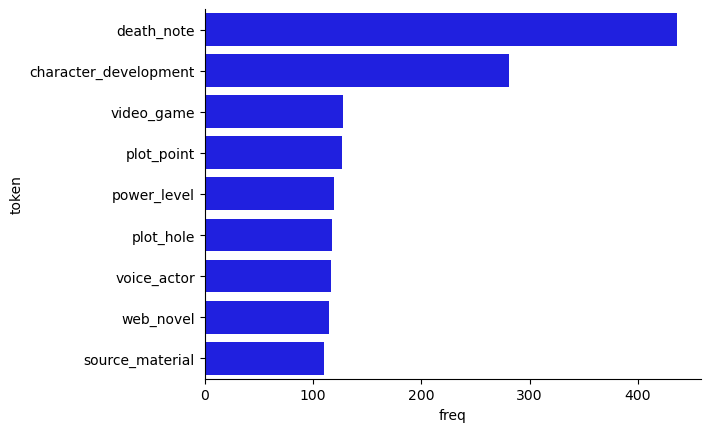

In [91]:
# let's see if we want to calculate the highest number of the noun phrases we have

import fun_preprocessing_text as pp_text_1

df_temp = pp_text_1.count_words(df, 'noun_phrases').head(12).reset_index()

sns.barplot(x='freq', y='token', 
            data=df_temp[~df_temp['token'].isin(['url__', '*_*', '__url'])], 
            label="Total", color="b")
sns.despine()

In [86]:
# we can save the dataframe as well to our already-built database

db_name = 'reddit-selfposts.db'
con = sqlite3.connect(db_name)
df.to_sql('anime-posts_nlp', con, index=False, if_exists='replace')
con.close()

,id,subreddit,title,raw_text,category,sub_category,sub2_category,text,impurity_clean_text,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities
0,83z5kr,KissAnime,Randomly getting “Block Ads” warning on site?,"I have NEVER had AdBlock, or any other type of...",anime/manga,kiss,None,Randomly getting “Block Ads” warning on site?:...,0.0,randomly get Block Ads warning on site?:I have...,get instal watch plentyy start lock block fix,Block Ads warning site?:I AdBlock type blocker...,,other_type other_day,never/ORG AdBlock/ORG
1,6dc2pb,KissAnime,So about this Captcha,I understand that there are post about this al...,anime/manga,kiss,None,So about this Captcha:I understand that there ...,0.0,so about Captcha understand that be post about...,understand holy ridiculous need stupid change ...,Captcha post shit shit episode show time episo...,website_thought,holy_shit stupid_shit long_show single_time ki...,Captcha/ORG KissAnime/ORG thought/PERSON
2,6j4brs,KissAnime,colorless videos,"So, recently, the videos on KissAnime have bee...",anime/manga,kiss,None,"colorless videos:So, recently, the videos on K...",0.0,colorless video so recently video on KissAnime...,colorless gray know mean multiple scryed ask g...,colorless video video KissAnime color anime Be...,,same_problem,KissAnime/ORG scryed/GPE Berserk/GPE
3,6e3fve,KissAnime,Where can i notify the owner/uploaders of kiss...,So i was watching baka to test and i want to t...,anime/manga,kiss,None,Where can i notify the owner/uploaders of kiss...,0.0,where can notify owner uploader of kissanime a...,notify have shitty watch test want tell nee up...,owner uploader kissanime anime sub?:So baka so...,,,un/ORG un/ORG
4,5z7dqh,KissAnime,[KODI] I found an alternate kissanime addon wh...,"If you log in in the settings, you can see you...",anime/manga,kiss,None,[KODI] I found an alternate kissanime addon wh...,0.0,kodi find alternate kissanime addon where post...,find alternate work break log entire play let ...,kissanime addon poster fanart metadata setting...,bookmark_folder working_order,alternate_kissanime entire_bookmark entire_boo...,metadata/PERSON trakt/GPE addon/GPE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25995,6x7d95,HunterXHunter,Hatsu which confuses you the most,"Hunter x hunter has a ton of different hatsus,...",anime/manga,hunter x hunter,None,Hatsu which confuses you the most:Hunter x hun...,0.0,Hatsu confuse most Hunter hunter have ton of d...,confuse different simple complex find confusin...,Hatsu Hunter hunter ton hatsus lot hatsus rest...,,different_hatsus,Hatsu/GPE Hunter/PERSON
25996,7iip96,HunterXHunter,Scanner in NGL not reacting to killua's needle?,"After the NGL arc, killua finds out about the ...",anime/manga,hunter x hunter,None,Scanner in NGL not reacting to killua's needle...,0.0,scanner in NGL react to killua needle?:after N...,react find get scan hide happen react bad,scanner NGL killua needle?:after NGL arc killu...,needle_right?(sorry,,NGL/GPE killua/PERSON NGL/ORG killua/PERSON NG...
25997,7e0xds,HunterXHunter,"I'm a little late to the party, but Ultra Inst...",So after googling Ultra Instinct God Speed and...,anime/manga,hunter x hunter,None,"I'm a little late to the party, but Ultra Inst...",0.0,be little late to party but Ultra Instinct be ...,little late Speed.:So google find compare sage...,party Ultra Instinct God Ultra Instinct God Sp...,hxh_reddit,blatant_rip unique_ability,Ultra_Instinct/PERSON Ultra_Instinct/PERSON Na...
25998,7l9shb,HunterXHunter,Something I've just realized about Chimera Ant...,So I've been thinking about the end of Chimera...,anime/manga,hunter x hunter,None,Something I've just realized about Chimera Ant...,0.0,'ve just realize about Chimera Ants Ending Tra...,realize think absolute stroke meruem know diso...,Chimera Ants Ending Tragedy SPOILER]:So end Ch...,palace_invasion,absolute_masterpiece meruem_side true_goal bri...,Chimera_Ants_Ending_Tragedy/ORG Chimera_Ants/O...
